# Version 0

Ignore Inclination. RN34

WNixalo - 21:48 21-Jan-2018

In [2]:
from fastai.conv_learner import *
from fastai.model import *
import json

In [4]:
def array_to_np_band(data_array, key=None):
    """Returns an (n,75,75,1) ndarray from Statoil radar bands"""
    if key==None:
        print("Error: Key not specified")
        return
    return np.expand_dims(np.array([np.array(band[key]).astype(np.float32).reshape(75,75) for 
                     band in data_array]), axis=-1)

In [3]:
with open('data/train.json') as jfile:
    train_dataset = json.load(jfile)

In [8]:
train_band_1 = array_to_np_band(train_dataset, 'band_1')
train_band_2 = array_to_np_band(train_dataset, 'band_2')
train_band_z = np.zeros(train_band_1.shape).astype(np.float32)

train_bands = np.concatenate([train_band_1, train_band_2, train_band_z], axis=-1)

In [9]:
labels  = np.array([datum['is_iceberg'] for datum in train_dataset])
train_ids = np.array([datum['id'] for datum in train_dataset])

In [10]:
n = len(labels)
val_idxs = get_cv_idxs(n)
val_idxs = np.array(val_idxs)

In [47]:
# because I don't know how to use split_by_idx properly, 
# and I want to get something done quickly (efficiency dies tonight)
trn_idxs = np.array([i for i in range(n) if i not in val_idxs])

In [49]:
# check to make sure nothing is in both sets
for i in range(n):
    if i in trn_idxs and i in val_idxs:
        print("oh shit")

In [64]:
# split train/val ids,labels,arrays
(val_y, trn_y) = (labels[val_idxs], labels[trn_idxs])
(val_ids, trn_ids) = (train_ids[val_idxs], train_ids[trn_idxs])
(val_data, trn_data) = (train_bands[val_idxs], train_bands[trn_idxs])

In [90]:
# more checking that the correct labels are going where they should
(False in np.isclose(labels[val_idxs[:]], val_y[:]),
 False in [i==j for i,j in zip(train_ids[val_idxs], val_ids)],
 False in np.isclose(train_bands[val_idxs], val_data))

(False, False, False)

In [85]:
a,b = ['a'],['b']
[i==j for i,j in zip(a,b)]

[False]

In [87]:
[[j,i] for i,j in zip(a,b)]

[['b', 'a']]

In [97]:
train_array = (trn_data,trn_y)
val_array   = (val_data,val_y)

My validation indices were all screwed up because I misused `split_by_idx`. I'll figure out how to use it properly later, but right now I want to get a basic set of submissions out tonight. So I did a very brute-force validation split above. Now that I'm confident the data is split properly, I'm going to restart training.

In [98]:
sz = 75
bs = 32
f_model = resnet34
PATH = 'data/'
tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
data = ImageClassifierData.from_arrays(PATH, train_array, val_array, tfms=tfms, bs=bs, 
                                       num_workers=8, classes=['0','1'], test=None)

In [99]:
learner = ConvLearner.pretrained(f_model, data, precompute=False)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 90%|█████████ | 37/41 [00:02<00:00, 13.70it/s, loss=8.8]  


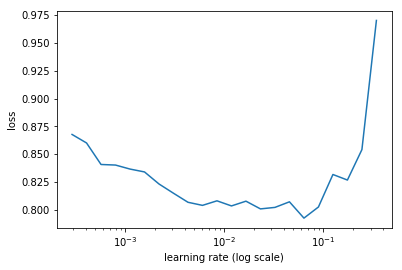

In [100]:
learner.lr_find()
learner.sched.plot()

In [101]:
lr = 2e-3

In [102]:
learner.fit(lrs=lr, n_cycle=1, cycle_len=1, cycle_mult=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch:   0, train_loss: 0.736958, val_loss: 45.370689, accuracy: 0.487500



In [103]:
learner.fit(lrs=lr, n_cycle=3, cycle_len=1, cycle_mult=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch:   0, train_loss: 0.692631, val_loss: 157.376373, accuracy: 0.487500
epoch:   1, train_loss: 0.699772, val_loss: 209.286774, accuracy: 0.487500
epoch:   2, train_loss: 0.672299, val_loss: 231.191452, accuracy: 0.487500



And I get exactly the same behavior as before.

In [104]:
learner.fit(lrs=lr, n_cycle=4, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

epoch:   0, train_loss: 0.691359, val_loss: 187.722580, accuracy: 0.487500
epoch:   1, train_loss: 0.675934, val_loss: 231.746490, accuracy: 0.487500
epoch:   2, train_loss: 0.638727, val_loss: 186.051117, accuracy: 0.487500
epoch:   3, train_loss: 0.619138, val_loss: 292.729095, accuracy: 0.487500
epoch:   4, train_loss: 0.605768, val_loss: 175.610397, accuracy: 0.487500
epoch:   5, train_loss: 0.599877, val_loss: 92.566299, accuracy: 0.487500
epoch:   6, train_loss: 0.606411, val_loss: 117.450378, accuracy: 0.487500
epoch:   7, train_loss: 0.619443, val_loss: 115.358292, accuracy: 0.487500
epoch:   8, train_loss: 0.612259, val_loss: 81.305344, accuracy: 0.487500
epoch:   9, train_loss: 0.619071, val_loss: 120.547073, accuracy: 0.487500
epoch:  10, train_loss: 0.604540, val_loss: 209.776276, accuracy: 0.487500
epoch:  11, train_loss: 0.600659, val_loss: 166.227341, accuracy: 0.487500
epoch:  12, train_loss: 0.594994, val_loss: 155.970917, accuracy: 0.487500
epoch:  13, train_loss: 0.5

Okay. This is not good.

22:30 21-Jan-2018